# Information

Python implementation of the learning framework proposed in [OrthoNet: Multilayer Network Data Clustering](https://arxiv.org/abs/1811.00821) published at *IEEE Transactions on Signal and Information Processing over Networks* (2020).

### Authors

- [Mireille El Gheche](http://www-syscom.univ-mlv.fr/~elgheche/)
- [Giovanni Chierchia](https://perso.esiee.fr/~chierchg/)
- Pascal Frossard

### License

This notebook is released under the [CeCILL-B](https://spdx.org/licenses/CECILL-B.html) license, which is fully compatible with BSD-like licenses (BSD, X11, MIT) with a strong attribution requirement.

### How to cite

- M. El Gheche, G. Chierchia, and P. Frossard. "OrthoNet: Multilayer Network Data Clustering," IEEE Transactions on Signal and Information Processing over Networks, Vol. 6, No. 1, pp. 13-23, December 2020.

```
@Article{ElGheche2019_tsipn,
  author  = {El Gheche, M. and Chierchia, G. and Frossard, P.},
  title   = {OrthoNet: Multilayer Network Data Clustering},
  journal = {IEEE Transactions on Signal and Information Processing over Networks},
  volume  = {6},
  number  = {1},
  pages   = {13--23},
  year    = {2020},
  month   = dec,
}
```

In [1]:
import math, random
import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from utils import *
from plots import *

# Datasets & Graphs

In this notebook, we consider a graph $\mathcal{G}(V,E)$ consisting of a set $V$ of vertices, and a set $E$ of edges with non-negative **similarity** weights $w_{ij}$, where $W = [w_{ij}]_{i,j} \in \mathbb{R}^{N\times N}$ is the weighted adjacency matrix with $w_{i,i} = 0$ for all $i$. The degree of a vertex $i$ is defined as the sum of weights of all the edges incident to $i$. The degree matrix $D$ is then defined as the following diagonal matrix

$$
D = \begin{bmatrix}
\sum_{j=1}^N w_{1j} & 0 & \dots & 0 \\
0 & \sum_{j=1}^N w_{2j} & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & \sum_{j=1}^N w_{Nj}
\end{bmatrix}.
$$

Based on $W$ and $D$, the Laplacian matrix of $\mathcal{G}$ is

$$
L = D - W.
$$

We further assume that each vertex of the graph $\mathcal{G}$ is associated with $M$-dimensional features, and we denote such data as

$$
X = 
\begin{bmatrix}
x_1^\top\\ 
\vdots\\ 
x_N^\top
\end{bmatrix} 
\in \mathbb{R}^{N\times M}.
$$

In [2]:
sets = generate_data()

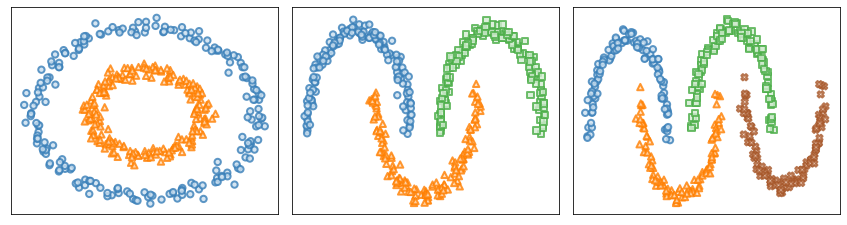

In [3]:
show_datasets(sets)

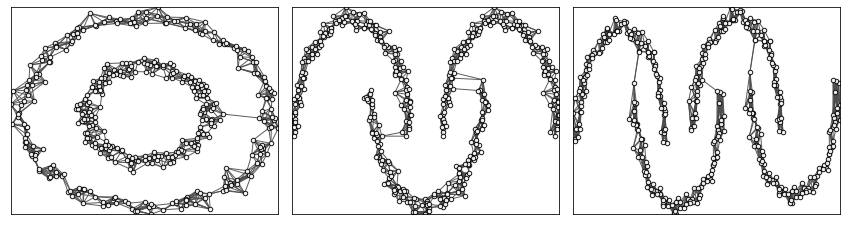

In [4]:
show_graphs(sets)

In [5]:
results = OrderedDict()

def add_result(experiment_name, set_name, embedding, net=None):
    e = results.setdefault(experiment_name, {})
    r = e.setdefault(set_name, {})
    e[set_name]['embedding'] = embedding
    e[set_name]['net'] = net

# Spectral clustering

The idea behind spectral clustering is to embed the nodes of a graph as points of a low-dimensional space, where they can be trivially clustered. More specifically, for a $K$-way clustering, one aims at finding the semi-orthogonal matrix $U = \left[ u_1 \,|\dots|\, u_N \right]^\top$ such that its rows $u_n \in \mathbb{R}^K$ minimize the pairwise distances on the graph edges, namely

$$
\operatorname*{minimize}_{U\in\mathbb{R}^{N\times K}}\;\;  
\operatorname{Tr}(U^\top LU) := \sum_{i=1}^N\sum_{j=1}^N w_{i,j} \|u_i - u_j\|^2 
\quad{\rm s.t.}\quad 
U^\top U = {\bf I_{K\times K}}.
$$

The solution to the above problem is the matrix formed by the eigenvectors associated to the $K$ smallest eigenvalues of the Laplacian matrix $L$. Each row of the solution $\bar{U}$ is a point in the low-dimensional space $\mathbb{R}^K$ representing a graph vertex. Strongly-connected vertices are mapped to close vectors in $\mathbb{R}^K$. One can then apply a $K$-mean algorithm on the rows of $\bar{U}$, so that $K$ clusters are formed by grouping together the vertices that are the most strongly connected by the graph.

In [6]:
def laplacian(graph, normed=False):
    W = graph.copy()
    np.fill_diagonal(W,0)
    d = np.sum(W, axis=0)    
    if normed:
        d = np.sqrt(d)
        D = np.diag(1/d)
        I = np.eye(W.shape[0])
        L = I - D.dot(W).dot(D)
    else:
        D = np.diag(d)
        I = np.eye(W.shape[0])
        L = D - W
    return L

def spectral_embedding(adjacency, n_clusters):
    L = laplacian(adjacency, normed=False)    
    _, V = scipy.linalg.eigh(L)
    E = V[:,:K]
    return E

In [7]:
for i, name in enumerate(sets):
    
    X = sets[name]["X"]
    y = sets[name]["y"]
    K = sets[name]["K"]
    G = sets[name]["G"]
    
    E = spectral_embedding(G, K)
    
    add_result('spectral', name, E)

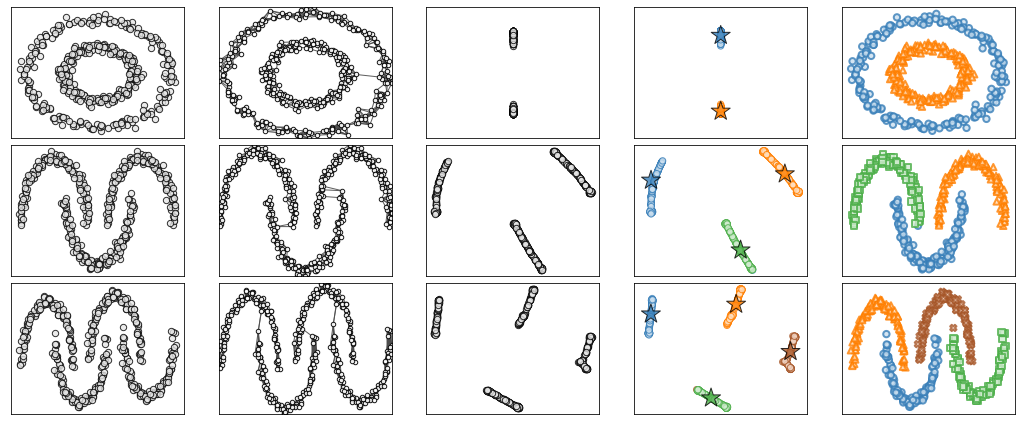

In [8]:
show_results(results, sets, 'spectral')

# OrthoNet

### Formulation

The proposed node feature embedding relies on both the node attributes $X$ and the Laplacian matrix $L=D-W$ of a given graph. The goal is to estimate a mapping $f_\theta$ that represents the features of strongly connected nodes as close points in the latent space. That is, for large similarities $w_{ij}$, we want the distance between $f_\theta(x_i)$ and $f_\theta(x_j)$ to be small, which amounts to minimizing

\begin{equation}
{\rm Tr}(Y_\theta^\top L Y_\theta) = \sum_{i=1}^N \sum_{j=1}^N w_{ij} \|f_\theta(x_i) - f_\theta(x_j)\|^2,
\end{equation}

where $Y_\theta = f_\theta(X)$. This objective is however not sufficient alone for learning an embedding that would result in effective clustering, as the sum of pairwise distances is trivially minimized by mapping all points to the same output vector. To avoid trivial solutions, we can borrow from spectral clustering the idea that the embedded points must be orthogonal to each other, yielding

\begin{equation}
\operatorname*{minimize}_{\theta\in\mathbb{R}^B}\;\;  {\rm Tr}(Y_\theta^\top L Y_\theta)
\quad{\rm s.t.} \quad 
Y_\theta^\top Y_\theta = {\bf I_{K\times K}}.
\end{equation}

The matrix $Y_\theta$ represents the graph nodes as vectors of the latent space $\mathbb{R}^K$. Intuitively, nodes within the same cluster should be mapped to close vectors, while nodes from different clusters should be spaced out from each other, so that the latent space can be easily clustered. By optimizing the sum of pairwise distances over the orthogonality constraint, the rows of $Y_\theta$ tend to be split into $K$ clusters, which are formed by grouping together the more strongly connected vertexes in the graph. This is indeed similar to spectral clustering, which uses the spectrum of the Laplacian matrix to perform dimensionality reduction before clustering.

### Learning algorithm

We propose to solve the above optimization problem through gradient descent. The main difficulty arises from the orthogonality constraint, since it is enforced on the mapping to be estimated, rather than the optimization parameters, ruling out standard techniques based on alternating optimization. To circumvent this issue, we propose to use the fact that the orthogonality constraint can be enforced implicitly by using the upper triangular matrix $R_\theta^\top \in\mathbb{R}^{K\times K}$ of the QR decomposition of $Y_\theta$, defined as

\begin{equation}
Y_\theta = Q_\theta R_\theta^\top,
\end{equation}

with $Q_\theta\in\mathbb{R}^{N\times K}$ being a semi-orthogonal matrix. Indeed, when $Y_\theta$ is full rank, or equivalently $Y_\theta^\top Y_\theta$ is positive definite, its QR decomposition is unique, and $R_\theta$ is equal to the lower triangular factor of the Cholesky decomposition 

\begin{equation}
Y_\theta^\top Y_\theta = R_\theta R_\theta^\top. 
\end{equation}

Therefore, the semi-orthogonal factor $Q_\theta$ can be extracted from the matrix $Y_\theta$ by multiplying it with $R_\theta^{-\top}$, namely

\begin{equation}
Q_\theta = Y_\theta R_\theta^{-\top} \quad\Rightarrow\quad Q_\theta^\top Q_\theta =  {\bf I_{K\times K}}.
\end{equation}

This consideration allows us to rewrite our problem as

$$ 
\operatorname*{minimize}_{\theta\in\mathbb{R}^B}\;\;  J(\theta) := {\rm Tr}(R_\theta^{-1} Y_\theta^\top L Y_\theta R_\theta^{-\top})
\quad \operatorname{s.t.} \quad 
R_\theta = {\rm Cholesky}(Y_\theta^\top Y_\theta).
$$

In the above reformulation, the term $Y_\theta$ is no longer a semi-orthogonal matrix. The constraint is now enforced implicitly through the factor $R_\theta$ derived from the Cholesky decomposition of $Y_\theta^\top Y_\theta$, which ensures that the product $Y_\theta R_\theta^{-\top}$ is a semi-orthogonal matrix of $\mathbb{R}^{N\times K}$. All operations involved in this reformulation are differentiable, provided that the mapping $f_\theta$ is differentiable, and thus the problem can be solved by gradient descent.

In [9]:
def build_net(input_dim, hidden_dim, output_dim):
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    
    net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim//2),
        nn.ReLU(),
        nn.Linear(hidden_dim//2, hidden_dim//3),
        nn.ReLU(),
        nn.Linear(hidden_dim//3, hidden_dim//4),
        nn.ReLU(),
        nn.Linear(hidden_dim//4, output_dim),
    )
    
    return net

In [10]:
class OrthoNet:
    
    def __init__(self, model, epochs, lr):
        self.model  = model
        self.epochs = epochs
        self.lr     = lr
        
    def fit(self, X, graph):
        self.setup(graph)
        self.train(X)
        
    def setup(self, graph):
        L = laplacian(graph)
        self.L = torch.from_numpy(L.astype(np.float32))
        self.m = math.sqrt(len(L))
        self.K = self.model[-1].out_features
        
    def loss(self, inputs):
        z = self.model(inputs)
        M = z.t().mm(z)
        R = torch.cholesky(M, upper=True)
        self.Q = self.m * torch.inverse(R)
        y = torch.mm(z, self.Q)
        loss = y.t().mm(self.L).mm(y).trace()
        return loss
    
    def train(self, X):
        inputs    = torch.from_numpy(X.astype(np.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, amsgrad=True)
        self.history = []
        self.model.train()
        for epoch in range(self.epochs+1):
            loss = self.loss(inputs)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            self.history.append(loss.item())
            if epoch == 0 or epoch % 500 == 0:
                print('Epoch {:4d}/{:d}: {:2.2f}'.format(epoch, self.epochs, loss.item()))  
        self.model.eval()
    
    def predict(self, X, orthogonal=True):
        inputs  = torch.from_numpy(X.astype(np.float32))
        outputs = self.model(inputs)
        if orthogonal:
            outputs = torch.mm(outputs, self.Q)
        return outputs.data.numpy()

### Test

In [11]:
for name in sets:
    
    X = sets[name]["X"]
    y = sets[name]["y"]
    K = sets[name]["K"]
    G = sets[name]["G"]

    model = build_net(X.shape[1], 250, K)

    net = OrthoNet(model, epochs=1000, lr=0.001)
    net.fit(X, G)
    E = net.predict(X)
    
    add_result('orthonet', name, E, net)

Epoch    0/1000: 47.70
Epoch  500/1000: 0.81
Epoch 1000/1000: 0.73
Epoch    0/1000: 158.99
Epoch  500/1000: 4.47
Epoch 1000/1000: 4.44
Epoch    0/1000: 145.89
Epoch  500/1000: 12.72
Epoch 1000/1000: 10.07


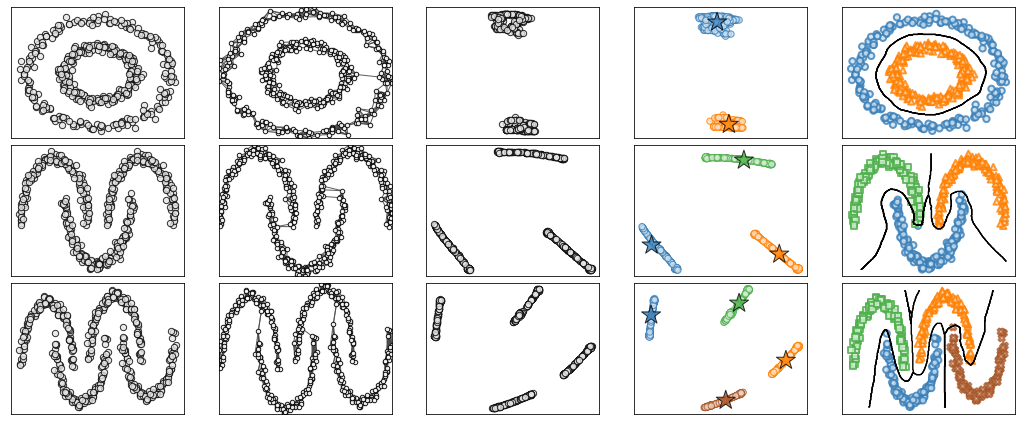

In [12]:
show_results(results, sets, 'orthonet')